# Use of EXIOBASE3.8
We will illustrate here the use of EXIOBASE by calculating EU GHG emissions from different perspectives.

Note: there is a bit of experimentation going on, for example the regionalization of the stressor matrix.

<thomas.gibon@list.lu>

Credit <maxime.agez@polymtl.ca> for the stressor extensions and characterization data

In [1]:
# Let's get comfortable first
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [76]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import SPA

Import the data. You'll need to have downloaded EXIOBASE 3.8 files from https://zenodo.org/record/4277368 into `EXIOBASE_PATH`.
I recommend using the command described below.
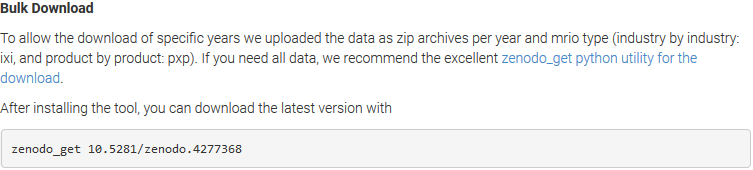

Then specify a year you want to work with. Note: in the 3.8 version, year 2019 has some issues, specifically for EU and Denmark in particular. You may want to choose another year instead.

The original characterization matrix is from https://zenodo.org/record/3955079/

...and you can find the stressors extension and characterization data at https://figshare.com/articles/dataset/Additional_environmental_extensions_for_EXIOBASE3_based_on_USEEEIO/12471278/1

In [3]:
year = 2018
EXIOBASE_PATH = '../exiobase/'

Then, just import the IO system with `pymrio`:

In [4]:
io = mr.parse_exiobase3(path=EXIOBASE_PATH+'IOT_{}_pxp.zip'.format(year))

Import the population data.

In [5]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

In [6]:
io.calc_all()

Import additional stressors.

In [7]:
# Credit to Maxime Agez for the stressor extension
stressors=pd.read_csv(EXIOBASE_PATH+'Expanded_S.csv',
                     index_col=[0],
                     header=[0,1])


In [8]:
stressors.shape

(1766, 9800)

In [9]:
stressors.columns=io.A.columns
short_S=io.satellite.S
short_S.shape

(1113, 9800)

In [10]:
io.satellite.S=pd.concat([short_S,stressors],axis=0)

In [11]:
io.satellite.S.shape

(2879, 9800)

In [12]:
io.satellite.F=io.satellite.S.mul(io.x['indout'])

In [13]:
F_Y_padding=pd.DataFrame(np.zeros([stressors.shape[0],io.satellite.F_Y.shape[1]]),
                        index=stressors.index,
                        columns=io.satellite.F_Y.columns)

In [14]:
io.satellite.F_Y=io.satellite.F_Y.append(F_Y_padding)

Run the various calculations (satellite factors, footprint reports, ...)

Import characterization.

In [15]:
Q_base=pd.read_csv(EXIOBASE_PATH+'C_exio_IW.csv',
             index_col=[0])
padding=short_S.shape[0]-Q_base.shape[1]
Q_energy=pd.DataFrame(np.zeros([Q_base.shape[0],padding]),
                     index=Q_base.index,
                     columns=short_S.index[-padding:])
Q_ext=pd.read_csv(EXIOBASE_PATH+'C_expansion_IW.csv',
             index_col=[0])

In [16]:
Q_base.shape

(36, 1104)

In [17]:
Q=pd.concat([Q_base,Q_energy,Q_ext],axis=1)
Q.shape

(36, 2879)

In [18]:
impact = dict()

In [19]:
impact['S'] = Q.dot(io.satellite.S) # unit stressors, per M€ 
impact['F'] = Q.dot(io.satellite.F) # total stressors
impact['F_Y'] = Q.dot(io.satellite.F_Y) # same for households
impact['name'] = 'impact' # and name
io.impact = mr.Extension(**impact) # finally, add it as a proper extension

In [20]:
io.calc_all()

In [21]:
ind='Climate change, short term (kg CO2 eq (short))'

In [22]:
GWP100_factors=Q.loc[ind]
GWP100_factors[GWP100_factors!=0]

CO2 - combustion - air                                                     1.00
CH4 - combustion - air                                                    36.00
N2O - combustion - air                                                   298.00
CO - combustion - air                                                      1.57
CH4 - non combustion - Extraction/production of (natural) gas - air       36.00
                                                                         ...   
Nitrogen fluoride - air - unspecified                                  17900.00
Nitrogen trifluoride - air - unspecified                               17900.00
Propane, 1,1,1,3,3,3-hexafluoro-, hcfc-236fa - air - unspecified        9000.00
Propane, perfluoro- - air - unspecified                                 9880.00
Sulfuryl fluoride - air - unspecified                                   4730.00
Name: Climate change, short term (kg CO2 eq (short)), Length: 78, dtype: float64

In [23]:
GWP100_factors[GWP100_factors!=0].to_excel('GWP100_EXIOBASE_factors.xlsx')

In [24]:
FD=io.impact.F_Y.loc[ind].unstack()

In [25]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 ).loc[['BE','DE','FR','LU']]

,"Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))"
region,,,,
BE,1.733630e+11,1.200066e+11,1.120951e+11,5.873873e+10
DE,1.152324e+12,9.809294e+11,4.718471e+11,3.004522e+11
FR,6.636409e+11,4.545440e+11,3.410432e+11,1.319463e+11
LU,1.551635e+10,1.063772e+10,1.297883e+10,8.100197e+09


In [26]:
io.population[['BE','DE','FR','LU']]

,BE,DE,FR,LU
population,11482000,83124000,64991000,604000


In [27]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 )

,"Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))","Climate change, short term (kg CO2 eq (short))"
region,,,,
AT,1.185876e+11,8.281365e+10,6.002207e+10,2.424817e+10
BE,1.733630e+11,1.200066e+11,1.120951e+11,5.873873e+10
BG,5.372546e+10,5.487870e+10,1.727300e+10,1.842623e+10
CY,1.420980e+10,1.622181e+10,7.345498e+09,9.357511e+09
CZ,1.400520e+11,1.285387e+11,4.549430e+10,3.398097e+10
DE,1.152324e+12,9.809294e+11,4.718471e+11,3.004522e+11
DK,8.419418e+10,6.968187e+10,4.939938e+10,3.488707e+10
EE,2.042486e+10,2.217665e+10,7.567427e+09,9.319220e+09
ES,4.180119e+11,3.638354e+11,1.730045e+11,1.188280e+11


In [28]:
pd.set_option('display.max_rows', 200)
research_employees_LU=io.satellite.D_pba['LU','Research and development services (73)'].iloc[9:15].sum()*1000

In [29]:
#https://statistiques.public.lu/stat/TableViewer/tableView.aspx?ReportId=13555&IF_Language=eng&MainTheme=4&FldrName=9&RFPath=2222
research_employees_LU=5468

In [30]:
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]

27411149.12073134

In [31]:
pd.set_option('display.max_rows', 200)
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

5013.011909424165

In [32]:
io.impact.D_pba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

431.39199303222284

In [33]:
io.impact.D_pba

region                                                     AT                \
sector                                             Paddy rice         Wheat   
Climate change, ecosystem quality, long term (P...        0.0  1.673722e+08   
Climate change, ecosystem quality, short term (...        0.0  7.999590e+07   
Climate change, human health, long term (DALY)            0.0  7.599955e+02   
Climate change, human health, short term (DALY)           0.0  3.704905e+02   
Climate change, long term (kg CO2 eq (long))              0.0  4.519152e+08   
Climate change, short term (kg CO2 eq (short))            0.0  4.526794e+08   
Freshwater acidification (PDF.m2.yr)                      0.0  9.972935e+06   
Freshwater acidification (kg SO2 eq)                      0.0  1.102969e+01   
Freshwater ecotoxicity (CTUe)                             0.0  7.516519e+08   
Freshwater ecotoxicity, long term (PDF.m2.yr)             0.0  3.493276e+05   
Freshwater ecotoxicity, short term (PDF.m2.yr)            0.0  6.253644e+04   
Freshwater eutrophication (PDF.m2.yr)                     0.0  3.587090e+05   
Freshwater eutrophication (kg PO4 P-lim eq)               0.0  3.146570e+04   
Human toxicity cancer (CTUh)                              0.0  9.499945e+00   
Human toxicity cancer, long term (DALY)                   0.0  7.640159e-03   
Human toxicity cancer, short term (DALY)                  0.0  1.092417e+02   
Human toxicity non cancer (CTUh)                          0.0  2.407737e-01   
Human toxicity non-cancer, long term (DALY)               0.0  3.904507e-01   
Human toxicity non-cancer, short term (DALY)              0.0  2.596383e-01   
Marine acidification, long term (PDF.m2.yr)               0.0  2.888599e+07   
Marine acidification, short term (PDF.m2.yr)              0.0  3.135598e+06   
Marine eutrophication (PDF.m2.yr)                         0.0  1.031139e+08   
Marine eutrophication (kg N N-lim eq)                     0.0  8.249114e+06   
Ozone Layer Depletion (kg  CFC-11 eq)                     0.0  1.114626e-06   
Ozone layer depletion (DALY)                              0.0  8.827904e-10   
Particulate matter formation (DALY)                       0.0  9.548205e+02   
Particulate matter formation (kg PM2.5 eq)                0.0  7.956838e+05   
Photochemical oxidant formation (DALY)                    0.0  7.641650e-02   
Photochemical oxidant formation (kg NMVOC eq)             0.0  1.959913e+06   
Terrestrial acidification (PDF.m2.yr)                     0.0  1.207891e+08   
Terrestrial acidification (kg SO2 eq)                     0.0  1.871830e+04   
Land occupation, biodiversity (m2 arable land e...        0.0  4.090227e+09   
Land occupation, biodiversity (PDF.m2.yr)                 0.0  2.865804e+09   
Fossil and nuclear energy use (MJ deprived)               0.0  0.000000e+00   
Mineral resources use (kg deprived)                       0.0  0.000000e+00   
Water scarcity (m3 world-eq)                              0.0  1.159073e+05   

region                                                                \
sector                                             Cereal grains nec   
Climate change, ecosystem quality, long term (P...      2.252690e+08   
Climate change, ecosystem quality, short term (...      1.280344e+08   
Climate change, human health, long term (DALY)          1.021500e+03   
Climate change, human health, short term (DALY)         5.932691e+02   
Climate change, long term (kg CO2 eq (long))            7.236528e+08   
Climate change, short term (kg CO2 eq (short))          7.247873e+08   
Freshwater acidification (PDF.m2.yr)                    1.877807e+07   
Freshwater acidification (kg SO2 eq)                    2.051465e+01   
Freshwater ecotoxicity (CTUe)                           8.310533e+08   
Freshwater ecotoxicity, long term (PDF.m2.yr)           3.861164e+05   
Freshwater ecotoxicity, short term (PDF.m2.yr)          6.925526e+04   
Freshwater eutrophication (PDF.m2.yr)                   9.198

In [34]:
io.impact.D_cba.loc[ind,'LU'].sum()

14056898689.105534

In [35]:
io.impact.D_cba.loc[ind,'LU'].sum()/440000

31947.497020694394

## Making own indicators

In [36]:
GWP100_unfccc=pd.Series(
[1,1,1,
34,34,34,34,34,34,34,34,34,34,
265,265]
    ,
index=
['CO2 - combustion - air',
 'CO2 - non combustion - Cement production - air',
 'CO2 - non combustion - Lime production - air',
 'CH4 - combustion - air',
 'CH4 - non combustion - Extraction/production of (natural) gas - air',
 'CH4 - non combustion - Extraction/production of crude oil - air',
 'CH4 - non combustion - Mining of antracite - air',
 'CH4 - non combustion - Mining of bituminous coal - air',
 'CH4 - non combustion - Mining of coking coal - air',
 'CH4 - non combustion - Mining of lignite (brown coal) - air',
 'CH4 - non combustion - Mining of sub-bituminous coal - air',
 'CH4 - non combustion - Oil refinery - air',
 'CH4 - agriculture - air',
 'N2O - combustion - air',
 'N2O - agriculture - air']
)

GWP100_unfccc

CO2 - combustion - air                                                   1
CO2 - non combustion - Cement production - air                           1
CO2 - non combustion - Lime production - air                             1
CH4 - combustion - air                                                  34
CH4 - non combustion - Extraction/production of (natural) gas - air     34
CH4 - non combustion - Extraction/production of crude oil - air         34
CH4 - non combustion - Mining of antracite - air                        34
CH4 - non combustion - Mining of bituminous coal - air                  34
CH4 - non combustion - Mining of coking coal - air                      34
CH4 - non combustion - Mining of lignite (brown coal) - air             34
CH4 - non combustion - Mining of sub-bituminous coal - air              34
CH4 - non combustion - Oil refinery - air                               34
CH4 - agriculture - air                                                 34
N2O - combustion - air   

Now we prepare the data for plotting.

## Bar chart of per-capita EU GHG emissions

In [37]:
method = GWP100_unfccc # hand-made method, in case you set up other method vectors

GHG_cba_tot = method.dot(io.satellite.D_cba_reg.loc[method.index])
GHG_pba_tot = method.dot(io.satellite.D_pba_reg.loc[method.index])
GHG_cba_cap = method.dot(io.satellite.D_cba_cap.loc[method.index])
GHG_pba_cap = method.dot(io.satellite.D_pba_cap.loc[method.index])
GHG_imp_tot = method.dot(io.satellite.D_imp_reg.loc[method.index])
GHG_exp_tot = method.dot(io.satellite.D_exp_reg.loc[method.index])
GHG_imp_cap = method.dot(io.satellite.D_imp_cap.loc[method.index])
GHG_exp_cap = method.dot(io.satellite.D_exp_cap.loc[method.index])
GHG_direct=method.dot(io.satellite.F_Y.loc[method.index]).groupby('region').sum()

In [38]:
footprints_EU_all_GHGs=pd.concat([io.impact.D_pba_reg.loc[ind],
                         io.impact.D_imp_reg.loc[ind],
                         io.impact.D_exp_reg.loc[ind],
                         io.impact.D_cba_reg.loc[ind],
                         io.impact.F_Y.loc[ind].groupby('region').sum()],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions'))

In [39]:
footprints_EU_UNFCCC=pd.concat([GHG_pba_tot,
                         GHG_imp_tot,
                         GHG_exp_tot,
                         GHG_cba_tot,
                         GHG_direct],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

In [40]:
footprints_EU_cap=pd.concat([GHG_pba_cap,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_cap,
                             GHG_direct.div(population.loc[year])],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000
footprints_EU_cap

,Production,Consumption,Direct emissions
IE,17.683715,14.092766,1.902085
LU,17.189226,24.036359,2.400781
GR,17.025343,14.044225,1.440969
EE,14.963896,14.012494,0.124588
NL,11.789352,13.443444,1.833290
CY,11.649833,10.857392,1.044866
DK,11.244163,13.662113,1.170268
DE,11.207251,13.079802,2.225771
CZ,10.973132,12.056176,1.221422
FI,10.876677,13.834255,1.162821


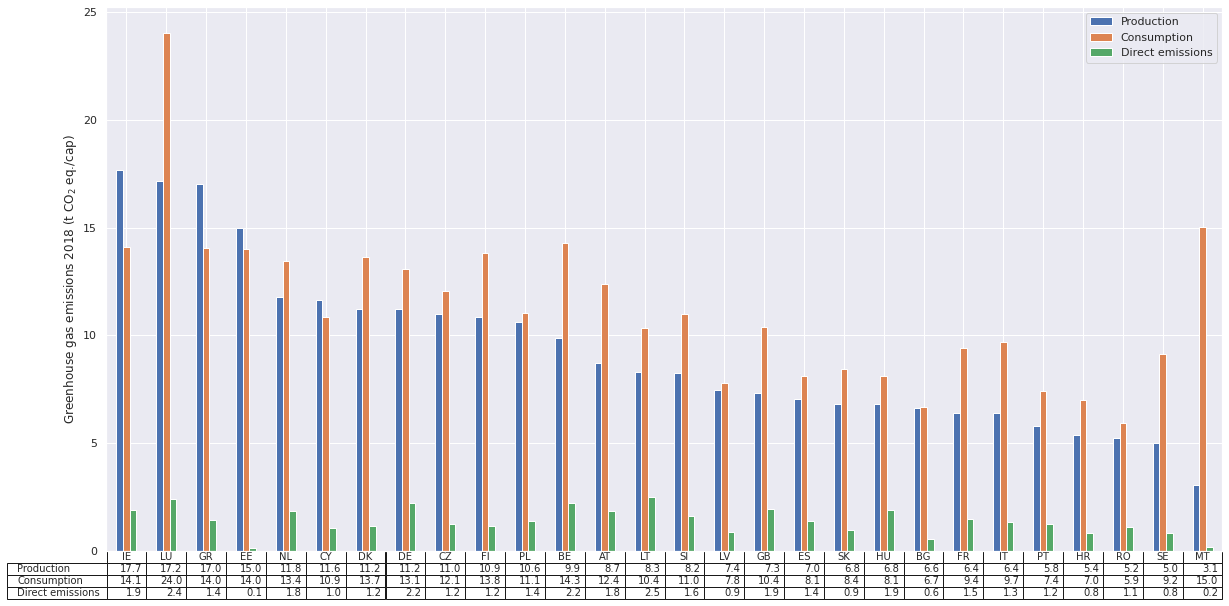

In [41]:
sns.set(font_scale=1)

fig,ax=plt.subplots(figsize=(20,10))
footprints_EU_cap.plot(kind='bar',ax=ax)
ax.set_ylabel(f'Greenhouse gas emissions {year} (t CO$_{2}$ eq./cap)')
ax.set_xticklabels([])
table = plt.table(colLabels=footprints_EU_cap.index,
          rowLabels=footprints_EU_cap.columns,
          cellText=footprints_EU_cap.T.round(1).values,loc='bottom')

table.set_fontsize(10)

In [42]:
footprints_EU_tot=pd.concat([GHG_pba_tot,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_tot,
                             GHG_direct],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)*1e-9
footprints_EU_tot.to_csv('footprint_EU_{}.csv'.format(year))

## Explore the carbon footprint of Luxembourg
I think $GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$ should work?

In [74]:
Y_LU = io.Y['LU'].sum(1)

In [72]:
GHG_cons_pro_LU=io.L.multiply(io.impact.S.loc[ind],axis=0).multiply(Y_LU)

In [73]:
GHG_cons_pro_LU['TOTAL'] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc['TOTAL'] = GHG_cons_pro_LU.sum(0)

/home/thomas.gibon/.conda/envs/refund/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='region-sector'>

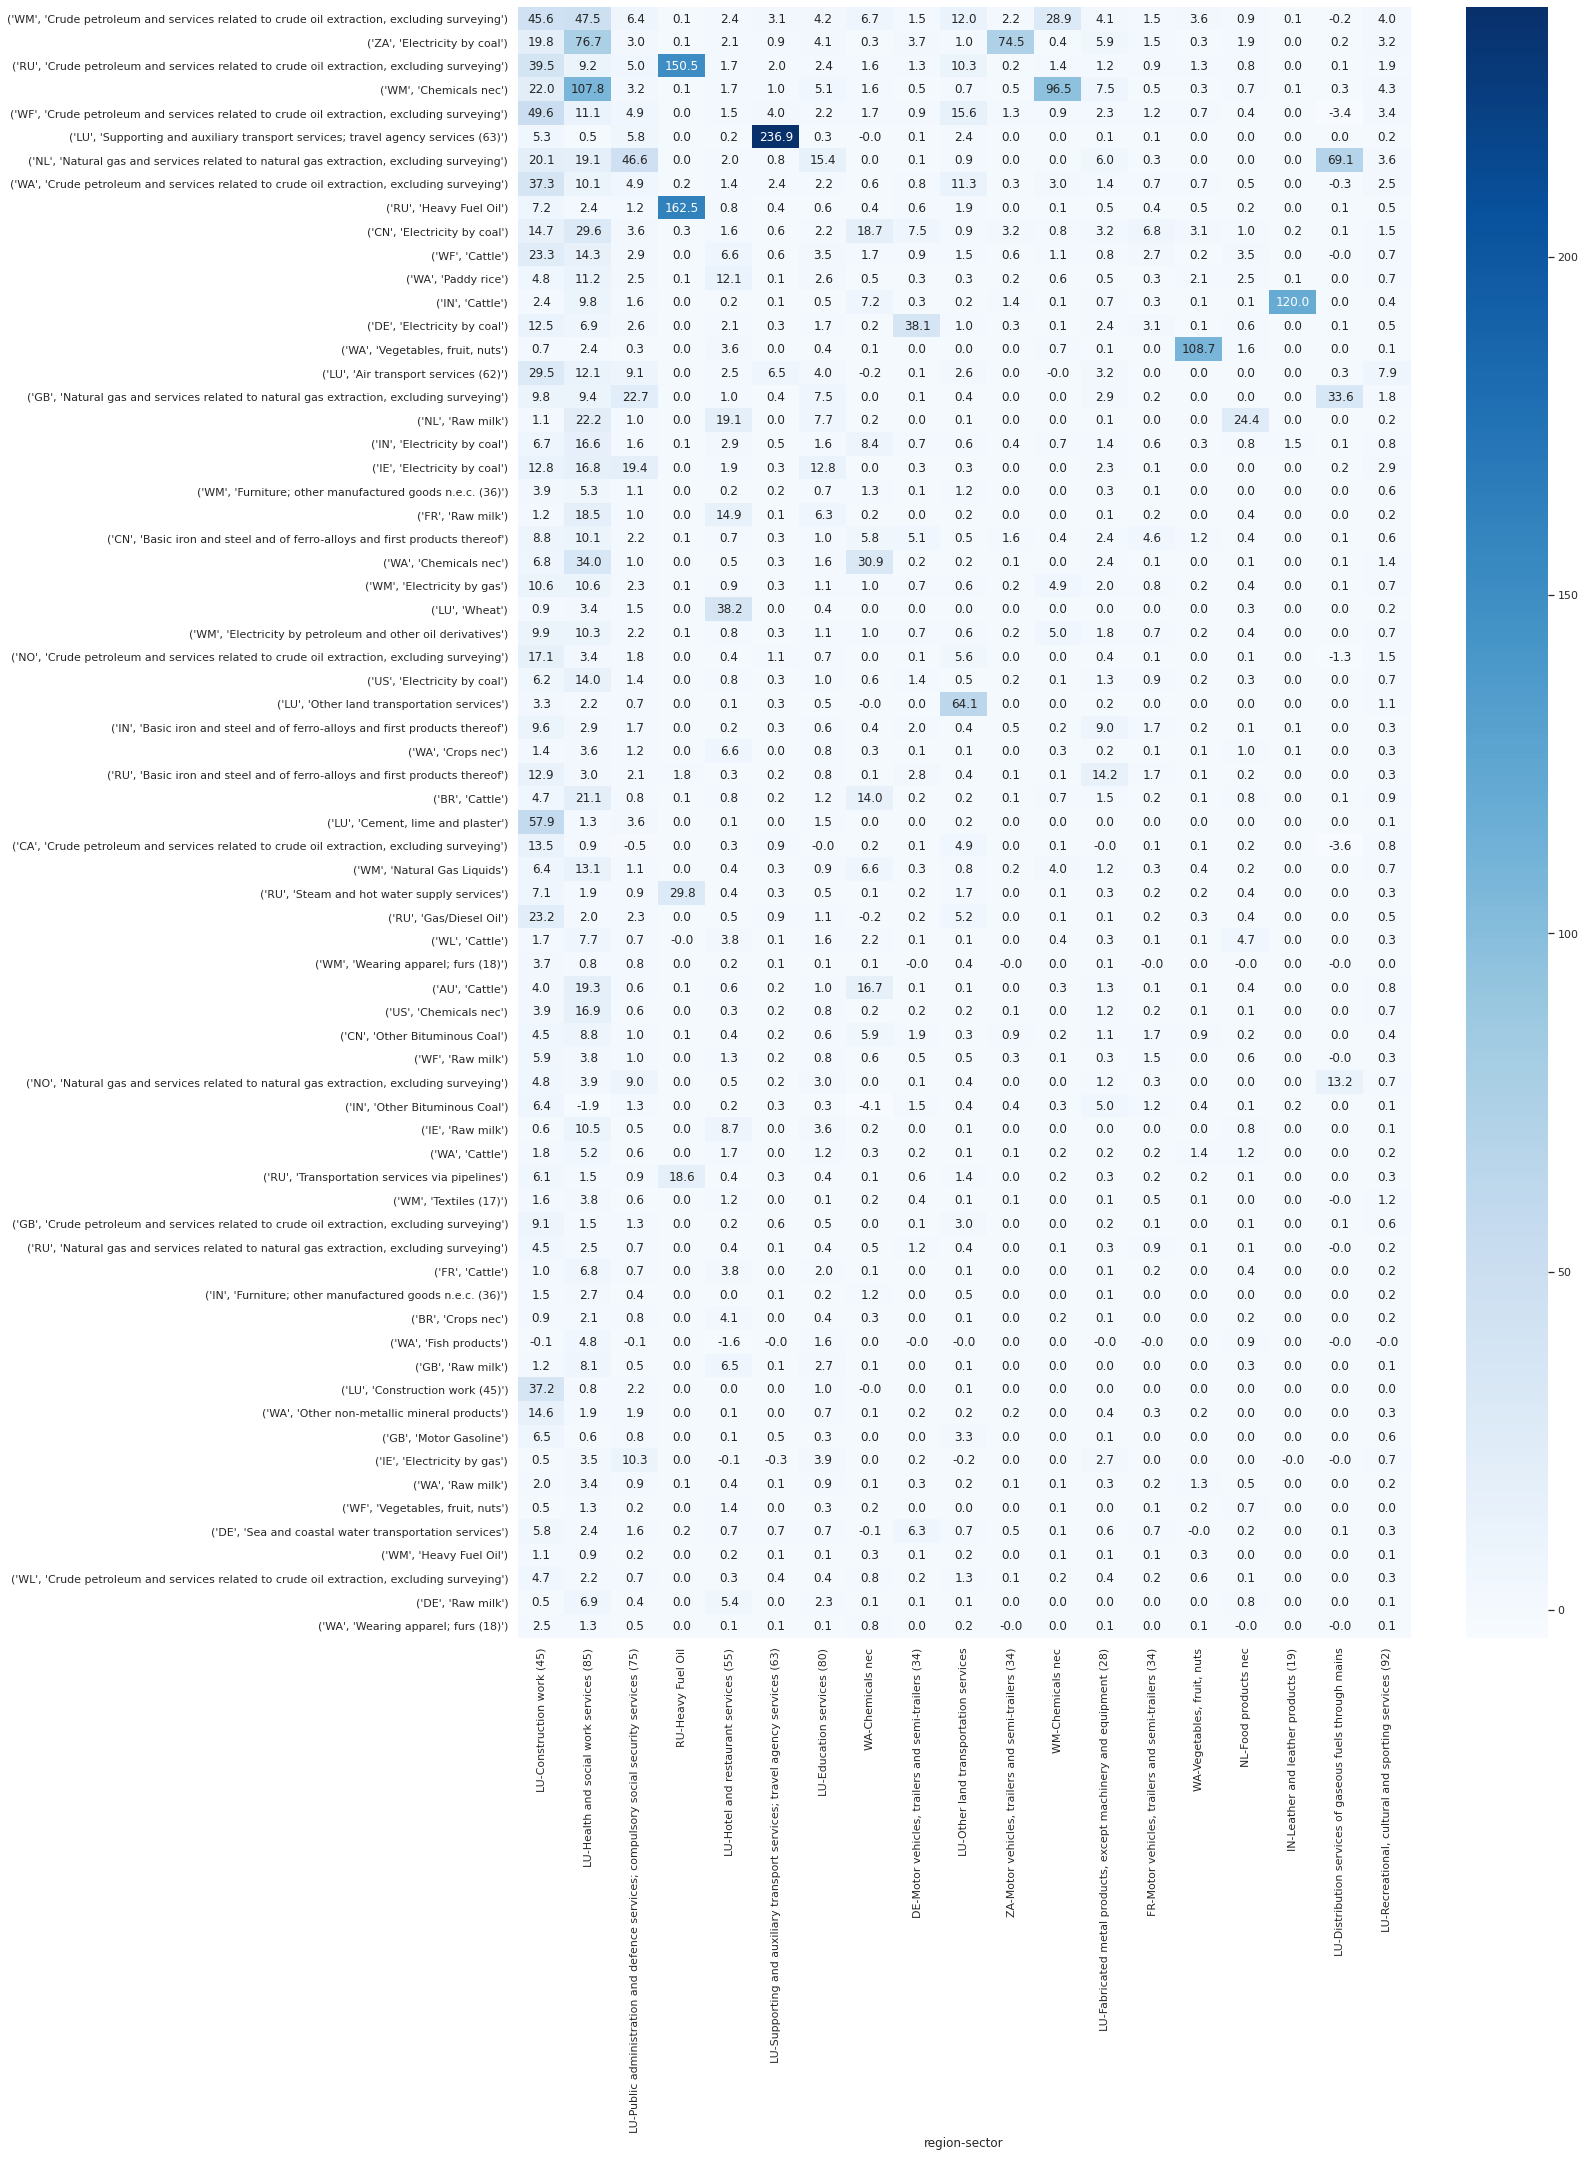

In [75]:
GHG_snap = GHG_cons_pro_LU.sort_values('TOTAL',axis=1,ascending=False).sort_values('TOTAL',ascending=False).iloc[:70,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6
fig, ax = plt.subplots(figsize=(20,30))
sns.heatmap(GHG_snap, annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues',
           fmt='.1f')

In [ ]:
# We can do a quick structural path analysis

region='LU'
scale=1

paths = SPA.SPA(io.impact.S.loc[ind]*scale,
            io.A,
            io.Y[region].sum(1),
            Tmax=30,
            threshold=.0001,
            filename=f'test_{region}_{ind}.csv',
            M=io.impact.M.loc[ind]*scale,
            direct=io.impact.F_Y[region].sum(1)[ind]*scale)

In [82]:
paths

,sequence,value,contribution,path
TOTAL,[],1.40569e+10,1,[]
REST,[],6.13644e+09,0.436543,[]
DIRECT,[],1.45945e+09,0.103825,[]
840,[3562],2.34069e+08,0.0166516,"[(LU, Supporting and auxiliary transport servi..."
1638,[7272],1.625e+08,0.0115601,"[(RU, Heavy Fuel Oil)]"
...,...,...,...,...
454,"[3539, 3540]",453.125,3.22351e-08,"[(LU, Transmission services of electricity), (..."
1224,"[3574, 8889, 8446]",234.477,1.66805e-08,"[(LU, Health and social work services (85)), (..."
1879,"[8889, 8446]",225.931,1.60726e-08,"[(WA, Chemicals nec), (ID, products of Vegetab..."
387,"[3495, 3495]",139.469,9.92171e-09,"[(LU, Rubber and plastic products (25)), (LU, ..."


## Extract multipliers
GHG emission factors per unit of final demand (for LIST carbon footprint exercise).
Aggregate EU28 then export M.

## Heatmap of global (or EU) GHG emissions embodied in trade

In [43]:
sns.set(font_scale=1)

n_sectors   = 163
n_sectors_Y = 7

method = GWP100_unfccc # in case you set up other method vectors

# create the GHG factors in GWP100 
S_GWP   = method.dot(io.satellite.S.loc[method.index])
F_GWP_Y = method.dot(io.satellite.F_Y.loc[method.index])

# and calculate the greenhouse gas emissions per sector of consumption for the intermediate consumption
GHG_cons_total = io.L.multiply(S_GWP,axis=0).dot(io.Y)

# group by region (we don't want sector resolution) and convert to Mt
GHG_cons_to_plot = GHG_cons_total.groupby('region',
                                    axis=1).sum().groupby('region',
                                                           axis=0).sum().reindex(io.get_regions(),
                                                                                 axis=0).reindex(io.get_regions(),
                                                                                                 axis=1)*1e-9

# same, for the emissions of final demand
GHG_cons_Y = pd.DataFrame(block_diag(*[F_GWP_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(49)]),
            index   = io.get_regions(),
            columns = io.Y.columns)
GHG_cons_Y_to_plot = GHG_cons_Y.groupby('region',axis=1).sum().reindex(io.get_regions(), axis=1)*1e-9

# sum them both
GHG_cons = GHG_cons_to_plot + GHG_cons_Y_to_plot

# and create column and row for production-based emissions and consumption-based emissions 
GHG_cons['EMBODIED IN\nPRODUCTION'] = GHG_cons.sum(1)
GHG_cons.loc['EMBODIED IN\nCONSUMPTION'] = GHG_cons.sum()

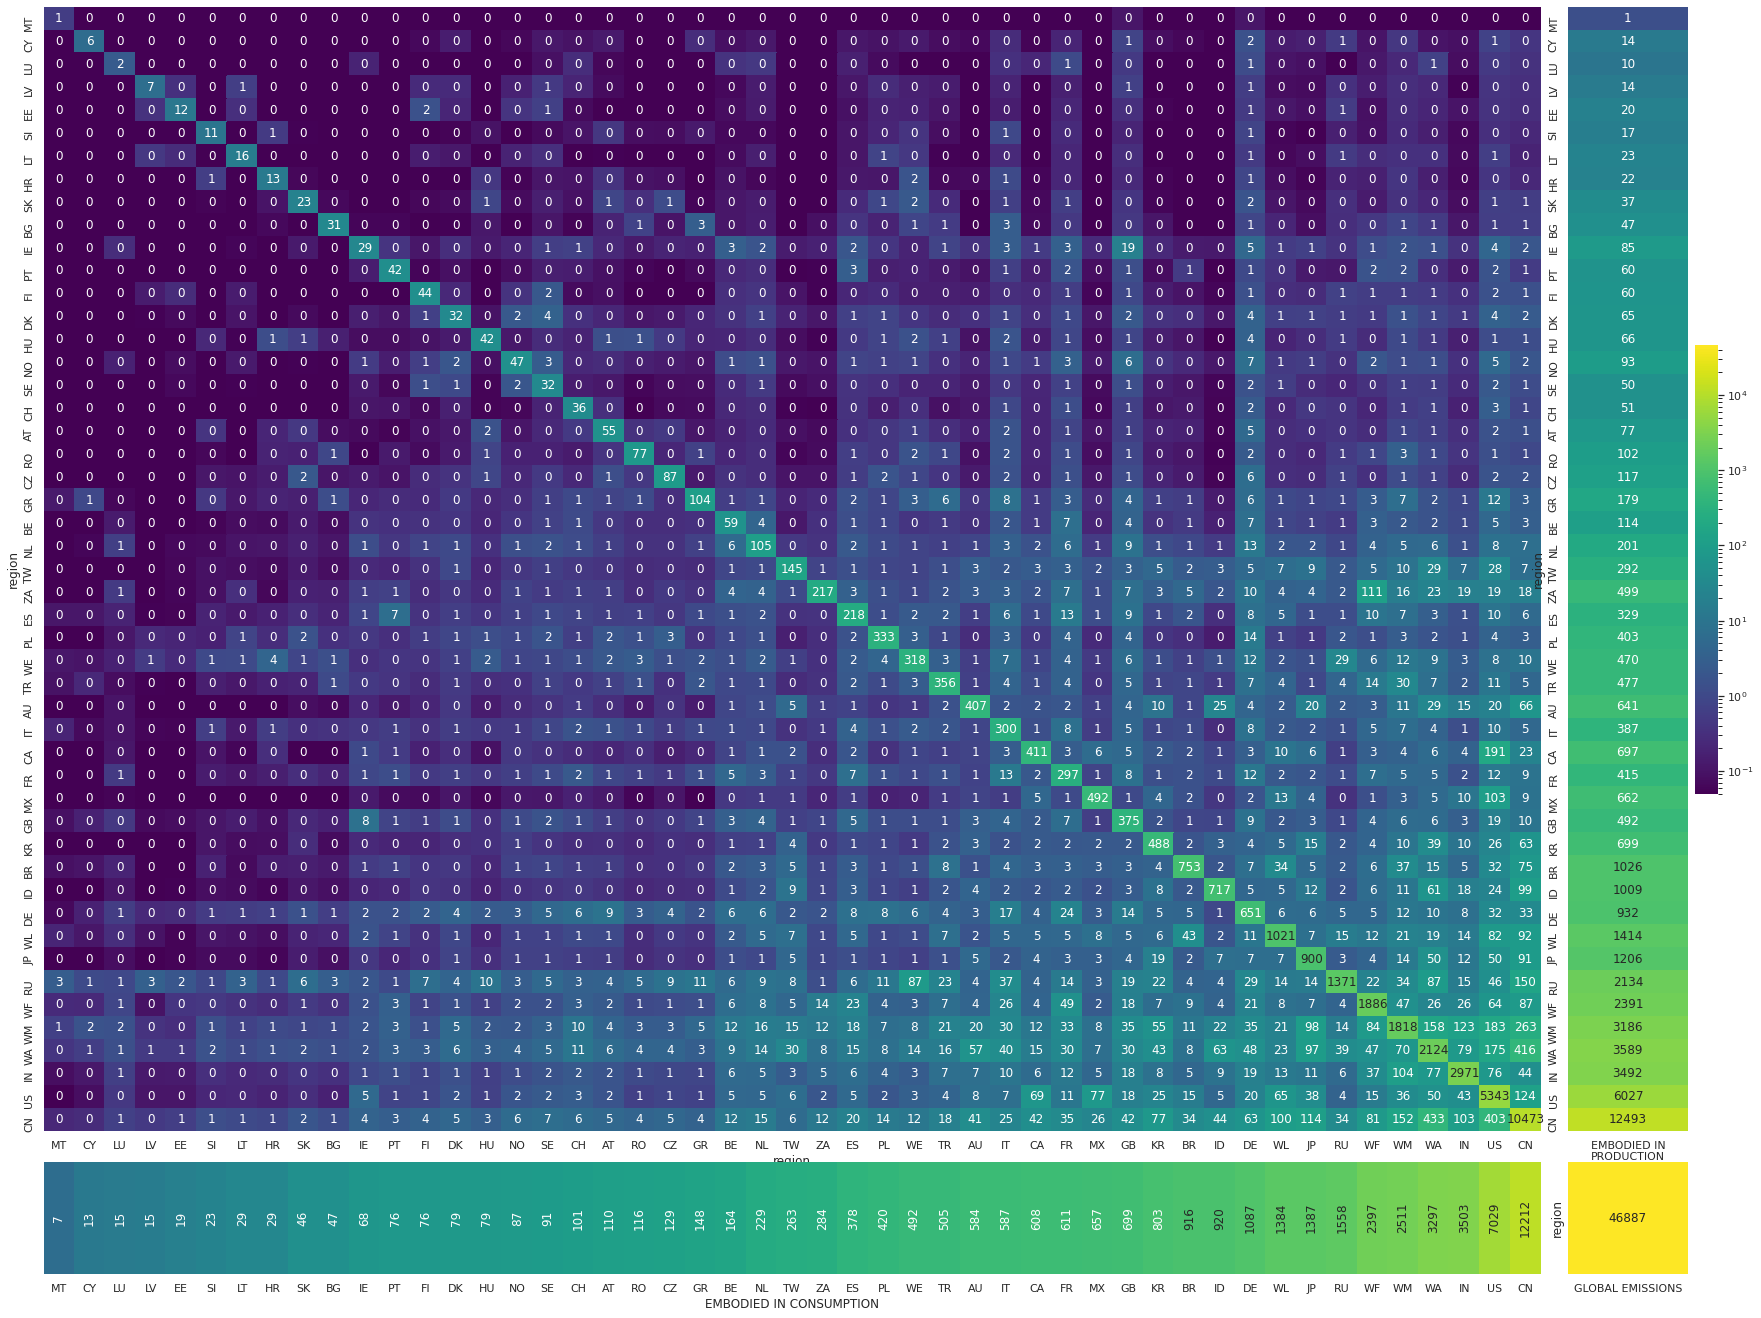

In [44]:
max_r = 49 # EU = 28, All = 49
cmap  = 'viridis'

GHG_cons_cutoff=GHG_cons.drop(GHG_cons.index[max_r:-1],axis=0).drop(GHG_cons.columns[max_r:-1],axis=1)

GHG_cons_sorted=GHG_cons_cutoff.sort_values(by='EMBODIED IN\nCONSUMPTION', axis=1)
GHG_cons_sorted=GHG_cons_sorted.reindex([*GHG_cons_sorted.columns[:-1],'EMBODIED IN\nCONSUMPTION'], axis=0)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(30, 20),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 1],
                                    'height_ratios': [10, 1],
                                    'wspace': 2/3*0.05,
                                    'hspace': 0.05,
                                    'bottom': 0})

sns.heatmap(GHG_cons_sorted.iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,0])
sns.heatmap(GHG_cons_sorted[GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,1])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:]].iloc[:max_r,:max_r], annot=True,
            annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[1,0])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:],GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='.0f',
           ax=ax[1,1])

ax[1,1].set_xlabel('')
ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION')
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])

# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.png'.format(year),
            facecolor='white',
            edgecolor='none')